# California Pacific Ocean Sound Recordings
https://registry.opendata.aws/pacific-sound/

https://docs.mbari.org/pacific-sound/notebooks/data/PacificSound256kHz/#apply-calibration

Works for one file at a time (10 minute spectrogram)

In [1]:
# get data from 2021

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal, interpolate
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import s3fs
import botocore
import os
import glob

## Trying to fetch .wav files online

In [2]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [3]:
bucket = 'pacific-sound-256khz-2021'

for i, obj in enumerate(s3.list_objects_v2(Bucket=bucket)['Contents']):
  print(obj['Key'])
  if i > 20:
      break

01/MARS_20210101_000424.wav
01/MARS_20210101_001424.wav
01/MARS_20210101_002424.wav
01/MARS_20210101_003424.wav
01/MARS_20210101_004424.wav
01/MARS_20210101_005424.wav
01/MARS_20210101_010424.wav
01/MARS_20210101_011424.wav
01/MARS_20210101_012424.wav
01/MARS_20210101_013424.wav
01/MARS_20210101_014424.wav
01/MARS_20210101_015424.wav
01/MARS_20210101_020424.wav
01/MARS_20210101_021424.wav
01/MARS_20210101_022424.wav
01/MARS_20210101_023424.wav
01/MARS_20210101_024424.wav
01/MARS_20210101_025424.wav
01/MARS_20210101_030424.wav
01/MARS_20210101_031424.wav
01/MARS_20210101_032424.wav
01/MARS_20210101_033424.wav


In [13]:
bucket = 'pacific-sound-256khz-2021'
filename = '01/MARS_20210101_000424.wav'
url = f'https://{bucket}.s3.amazonaws.com/{filename}'
#print(f'Reading metadata from {url}')
#sf.info(io.BytesIO(urlopen(url).read()), verbose=True)

In [4]:
# Fetch all urls
s3 = s3fs.S3FileSystem(anon=True)

# List the files available
audio_files = s3.ls("pacific-sound-256khz-2021/01")

In [11]:
audio_files[0]

'pacific-sound-256khz-2021/01/MARS_20210101_000424.wav'

In [51]:
### Fetch from online repository
### This is taking ages... why???
%%prun
with s3.open(audio_files[0]) as f:
    x, sample_rate = sf.read(io.BytesIO(f.read()),dtype='float32')

## Save files locally on disk

In [5]:
# To save the files on disk instead
s3 = s3fs.S3FileSystem(anon=True)
bucket_name = 'pacific-sound-256khz-2021'
fp = s3.glob(f"{bucket_name}/**/*.wav")[::20]

In [6]:
fp

['pacific-sound-256khz-2021/01/MARS_20210101_000424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_032424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_064424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_100424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_132424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_164424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_200424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_232424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_024424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_060424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_092424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_124424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_160424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_192424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_224423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210103_020423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210103_052423.wav',
 'pacific-soun

In [8]:
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [9]:
for f in fp:
    file_name = os.path.basename(f)
    out_file = f'data/california-pam/{file_name}'
    client.download_file(
        Bucket=bucket_name,
        Key=os.path.relpath(f, bucket_name),
        Filename=out_file
    )

KeyboardInterrupt: 

## Read files from local disk

In [41]:
# List files available in folder
files = glob.glob('data/california-pam/*wav')

In [50]:
print(f'Reading data from file')
with open(files[2],'rb') as f:
    x, sample_rate = sf.read(io.BytesIO(f.read()),dtype='float32')

Reading data from file


## Conversions and calibrations

In [51]:
def CalibLTSA(x, sample_rate):

    # convert scaled voltage to volts
    v = x*3 
    nsec = (v.size)/sample_rate # number of seconds in vector
    spa = 1  # seconds per average
    nseg = int(nsec/spa)
    print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')
            
    # initialize empty LTSA
    nfreq = int(sample_rate/2+1)
    nfreq,nseg
    sg = np.empty((nfreq, nseg), float)
    sg.shape
    
    # get window for welch
    w = scipy.signal.get_window('hann',sample_rate)

    # process spectrogram
    for x in range(0,nseg):
        cstart = x*spa*sample_rate
        cend = (x+1)*spa*sample_rate
        f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
        psd = 10*np.log10(psd)
        sg[:,x] = psd
        
    # define hydrophone calibration data
    calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
    calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

    # interpolate to the frequency resolution of the spectrogram
    tck = interpolate.splrep(calfreq, calsens, s=0)
    isens = interpolate.splev(f, tck, der=0)
    
    return sg, isensg

In [52]:
sg, isensg = CalibLTSA(x, sample_rate)

600 segments of length 1 seconds in 600.0 seconds of audio


## Plotting spectrogram

Text(0.5, 1.0, 'Calibrated spectrum levels')

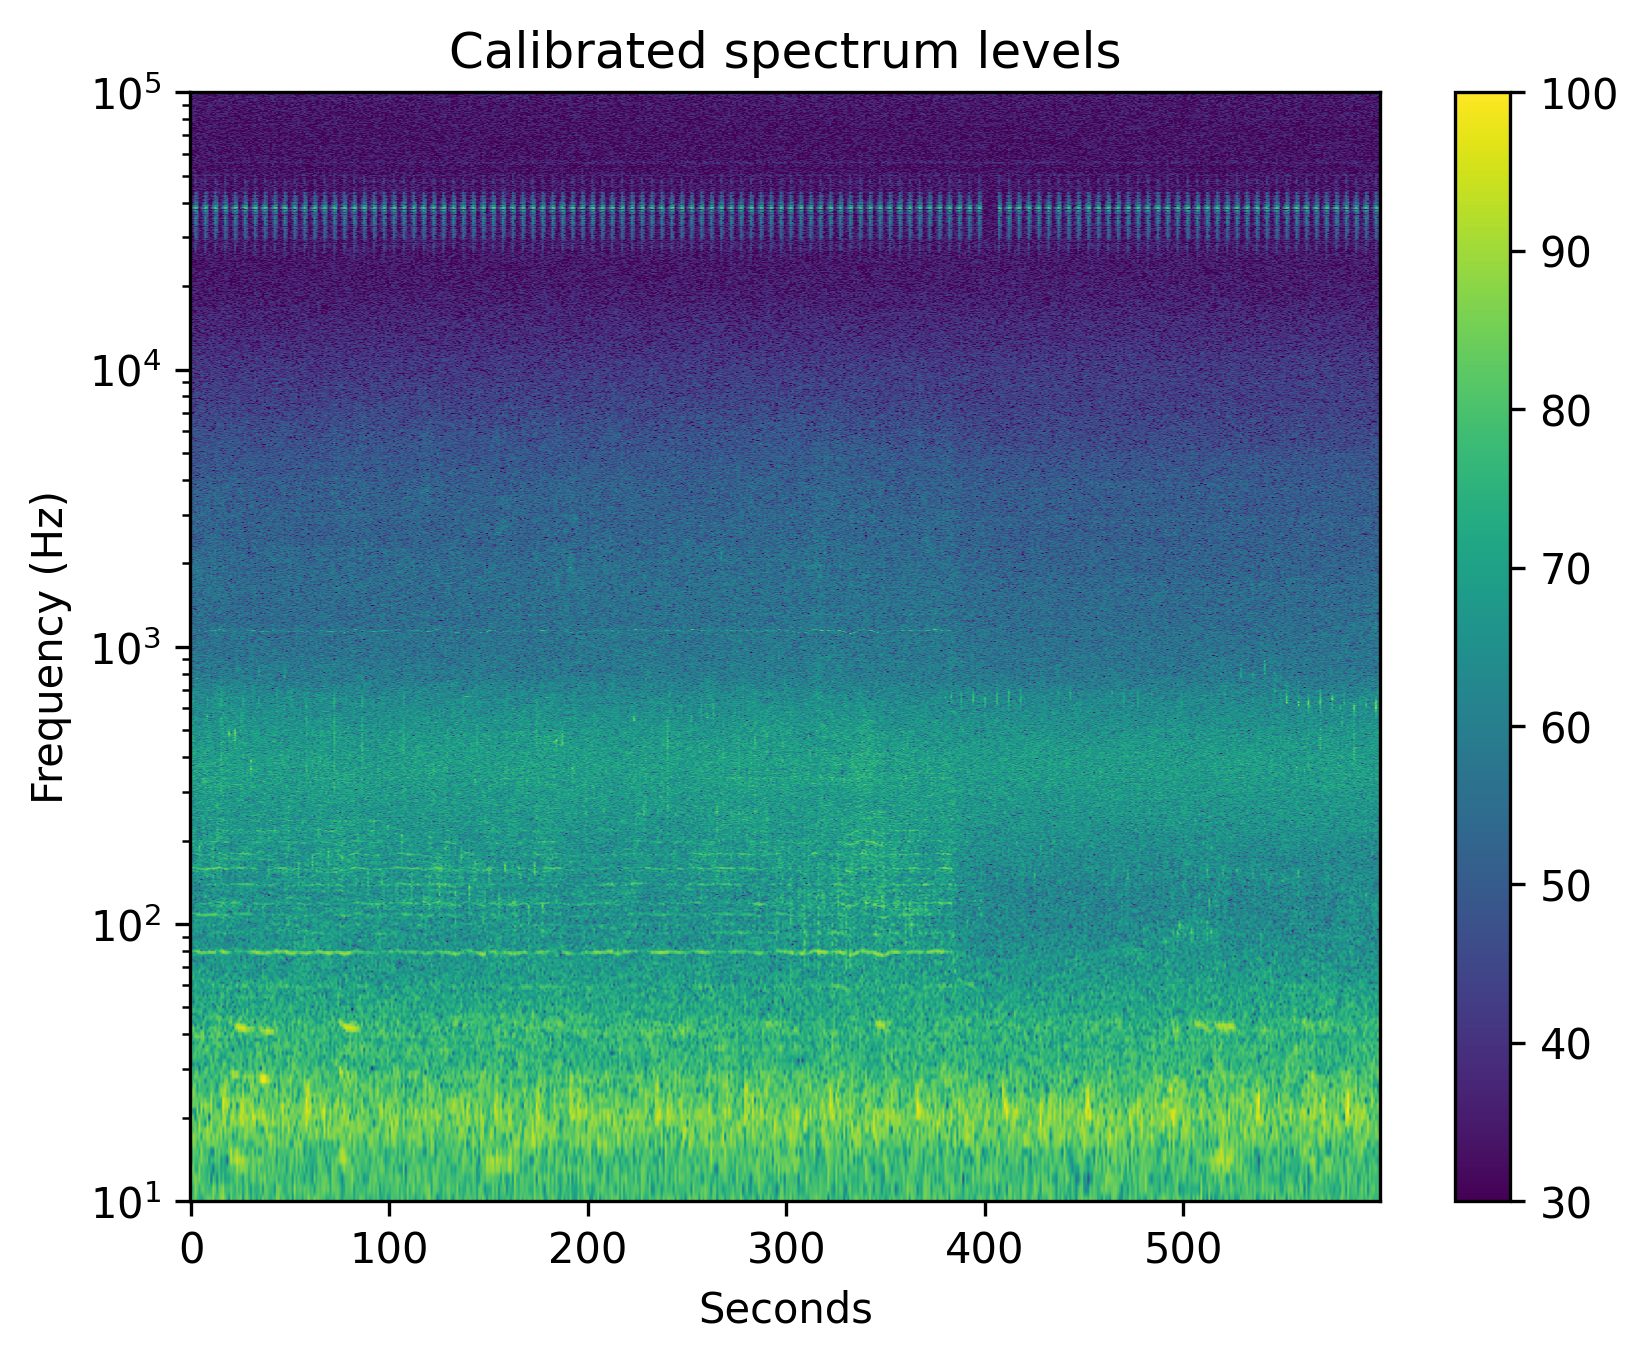

In [53]:
plt.figure(dpi=300)
im = plt.imshow(sg-isensg,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,100000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')